In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

🔒 Random seed set to 42 for reproducibility.


In [ ]:
import google.generativeai as genai
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import io
import adjustText
import gc
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import userdata

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
save_path =  OUT_DIR / "brca_msc_benchmark_data.h5ad"

print(f"\n Loading data...: {save_path}")
adata= sc.read_h5ad(save_path)
print("\nCell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):")
print(adata.obs['meta.cluster'].value_counts().head(10))


 Loading data...: /runs/20251201.v1/brca_msc_benchmark_data.h5ad

Cell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):
meta.cluster
CAFs MSC iCAF-like    300
CAFs myCAF-like       300
Endothelial ACKR1     300
Endothelial CXCL12    300
PVL Differentiated    300
Endothelial RGS5      300
PVL Immature          300
Cycling PVL            50
Name: count, dtype: int64


Applying MSC/CAF Ground Truth Mapping...

--- Value Counts (Check for 'Other') ---
GT_Category
Endothelial    900
Fibro_PVL      650
Fibro_iCAF     300
Fibro_myCAF    300
Name: count, dtype: int64
  Generating UMAP...
  Calculating dendrogram...
  Plotting DotPlot...
categories: Endothelial, Fibro_PVL, Fibro_iCAF, etc.
var_group_labels: Endothelial, Fibro_iCAF, Fibro_myCAF, etc.
Done.


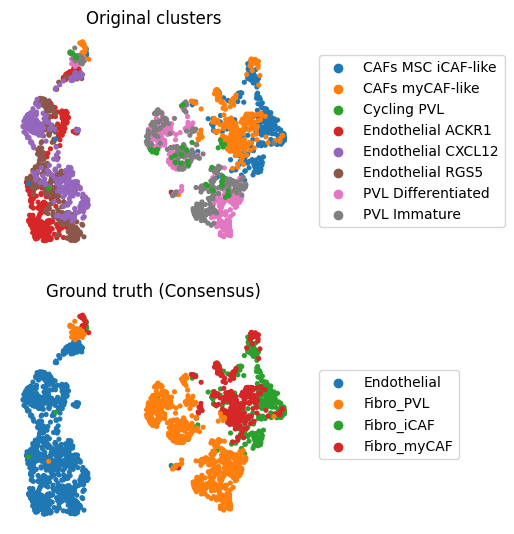

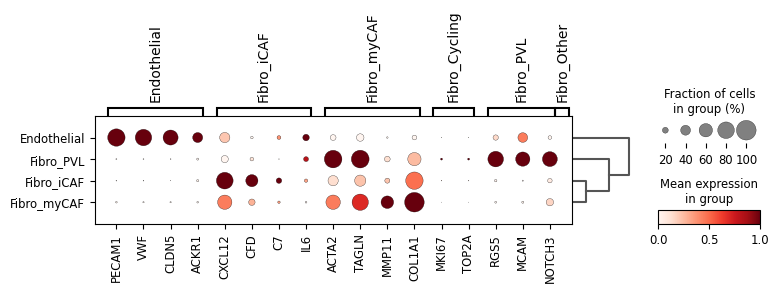

In [ ]:
# ==========================================
# Correct Label Generation Function
# Definition based on cluster IDs from Wu et al., 2021
# ==========================================
def get_msc_ground_truth(cluster_name: str) -> str:
    """
    Ground-truth mapping for the CAF / MSC benchmark.

    We deliberately collapse the space into a small set of biologically
    interpretable states:
        - Fibro_iCAF      (MSC / inflammatory CAFs)
        - Fibro_myCAF     (myofibroblastic / activated CAFs)
        - Fibro_PVL       (perivascular / pericyte / smooth muscle lineage)
        - Fibro_Cycling   (cycling fibroblasts that are not clearly PVL)
        - Endothelial     (vascular endothelial lineage)
    """
    s = str(cluster_name).lower()

    # 1) Endothelial lineages
    if "endothelial" in s or "blood vessel" in s or "blood vessels" in s:
        return "Endothelial"

    # 2) PVL / perivascular / pericyte / smooth muscle clusters
    #    (including "Cycling PVL" – PVL is the primary signal here)
    if any(k in s for k in ["pvl", "perivascular", "pericyte", "smooth muscle"]):
        return "Fibro_PVL"

    # 3) iCAF-like MSC clusters
    if any(k in s for k in ["icaf", "msc"]):
        return "Fibro_iCAF"

    # 4) myCAF-like clusters
    if any(k in s for k in ["mycaf", "myofibroblast"]):
        return "Fibro_myCAF"

    # 5) Cycling fibroblasts (that are not clearly PVL / endothelial)
    if any(k in s for k in ["cycling", "proliferating", "mki67", "top2a"]):
        return "Fibro_Cycling"

    # 6) Fallback
    return "Fibro_Other"


print("Applying MSC/CAF Ground Truth Mapping...")
adata.obs['GT_Category'] = adata.obs['meta.cluster'].apply(get_msc_ground_truth)

print("\n--- Value Counts (Check for 'Other') ---")
print(adata.obs['GT_Category'].value_counts())

print("  Generating UMAP...")
sc.pp.neighbors(adata, random_state=42)
sc.tl.umap(adata, random_state=42)
fig = sc.pl.umap(
    adata,
    color=['meta.cluster', 'GT_Category'],
    legend_fontsize=10,
    ncols=1,
    title=['Original clusters', 'Ground truth (Consensus)'],
    frameon=False,
    return_fig=True
)

# Layout adjustment
for ax in fig.axes:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.set_size_inches(4, 6)
fig.tight_layout(rect=[0, 0, 0.85, 1])
fig.savefig(f"{OUT_DIR}/EDFig1d_MSC_GT_Check.pdf", bbox_inches='tight')


# ==========================================
# 4. DotPlot (Biologically Strict)
# ==========================================
# - iCAF: C7, CXCL12 (chemokines), CFD
# - myCAF: ACTA2 (SMA), TAGLN, COL1A1 (high matrix)
# - PVL: RGS5 (classic), MCAM (CD146)
# - Endothelial: PECAM1 (CD31), VWF
# - Endothelial RGS5 check: Does it express PECAM1? Or only RGS5?

GT_KEYWORDS_MSC = {
    "Endothelial":   ["PECAM1", "VWF", "CLDN5", "ACKR1"],
    "Fibro_iCAF":    ["CXCL12", "CFD", "C7", "IL6"],
    "Fibro_myCAF":   ["ACTA2", "TAGLN", "MMP11", "COL1A1"],
    "Fibro_Cycling": ["MKI67", "TOP2A"],
    "Fibro_PVL":     ["RGS5", "MCAM", "NOTCH3"],
    "Fibro_Other":   [],   # catch-all; marker list is intentionally空
}

# Filter markers
var_names = adata.var_names
filtered_markers = {k: [g for g in v if g in var_names] for k, v in GT_KEYWORDS_MSC.items()}

print("  Calculating dendrogram...")
sc.tl.dendrogram(adata, groupby='GT_Category')

print("  Plotting DotPlot...")
fig = sc.pl.dotplot(
    adata,
    filtered_markers,
    groupby='GT_Category',
    dendrogram=True,
    standard_scale='var',
    return_fig=True
)
fig.savefig(f"{OUT_DIR}/EDFig1g_MSC.pdf", bbox_inches='tight')
print("Done.")